In [1]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [4]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    'data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('../write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


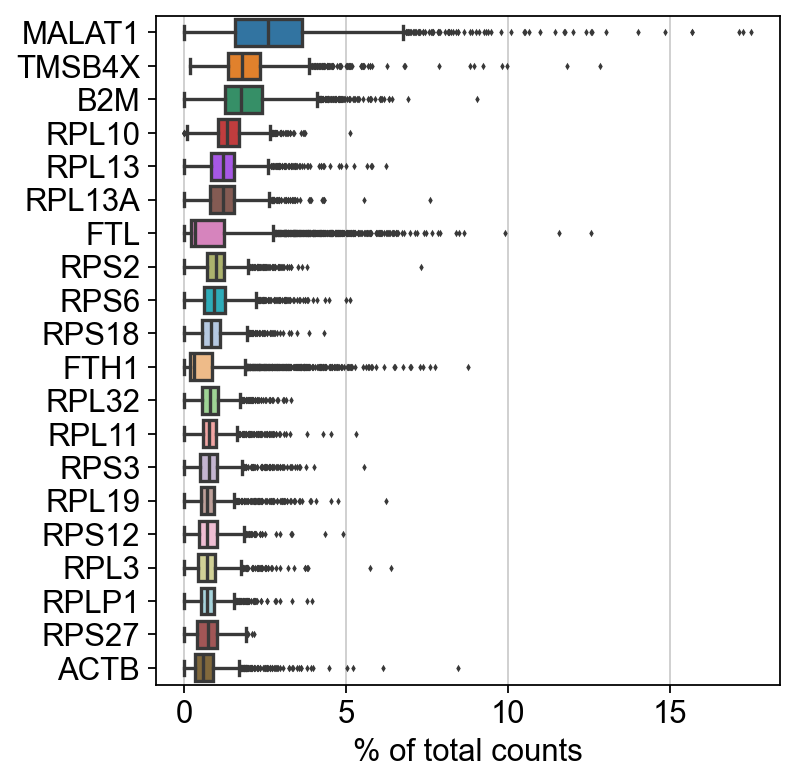

In [5]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [6]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


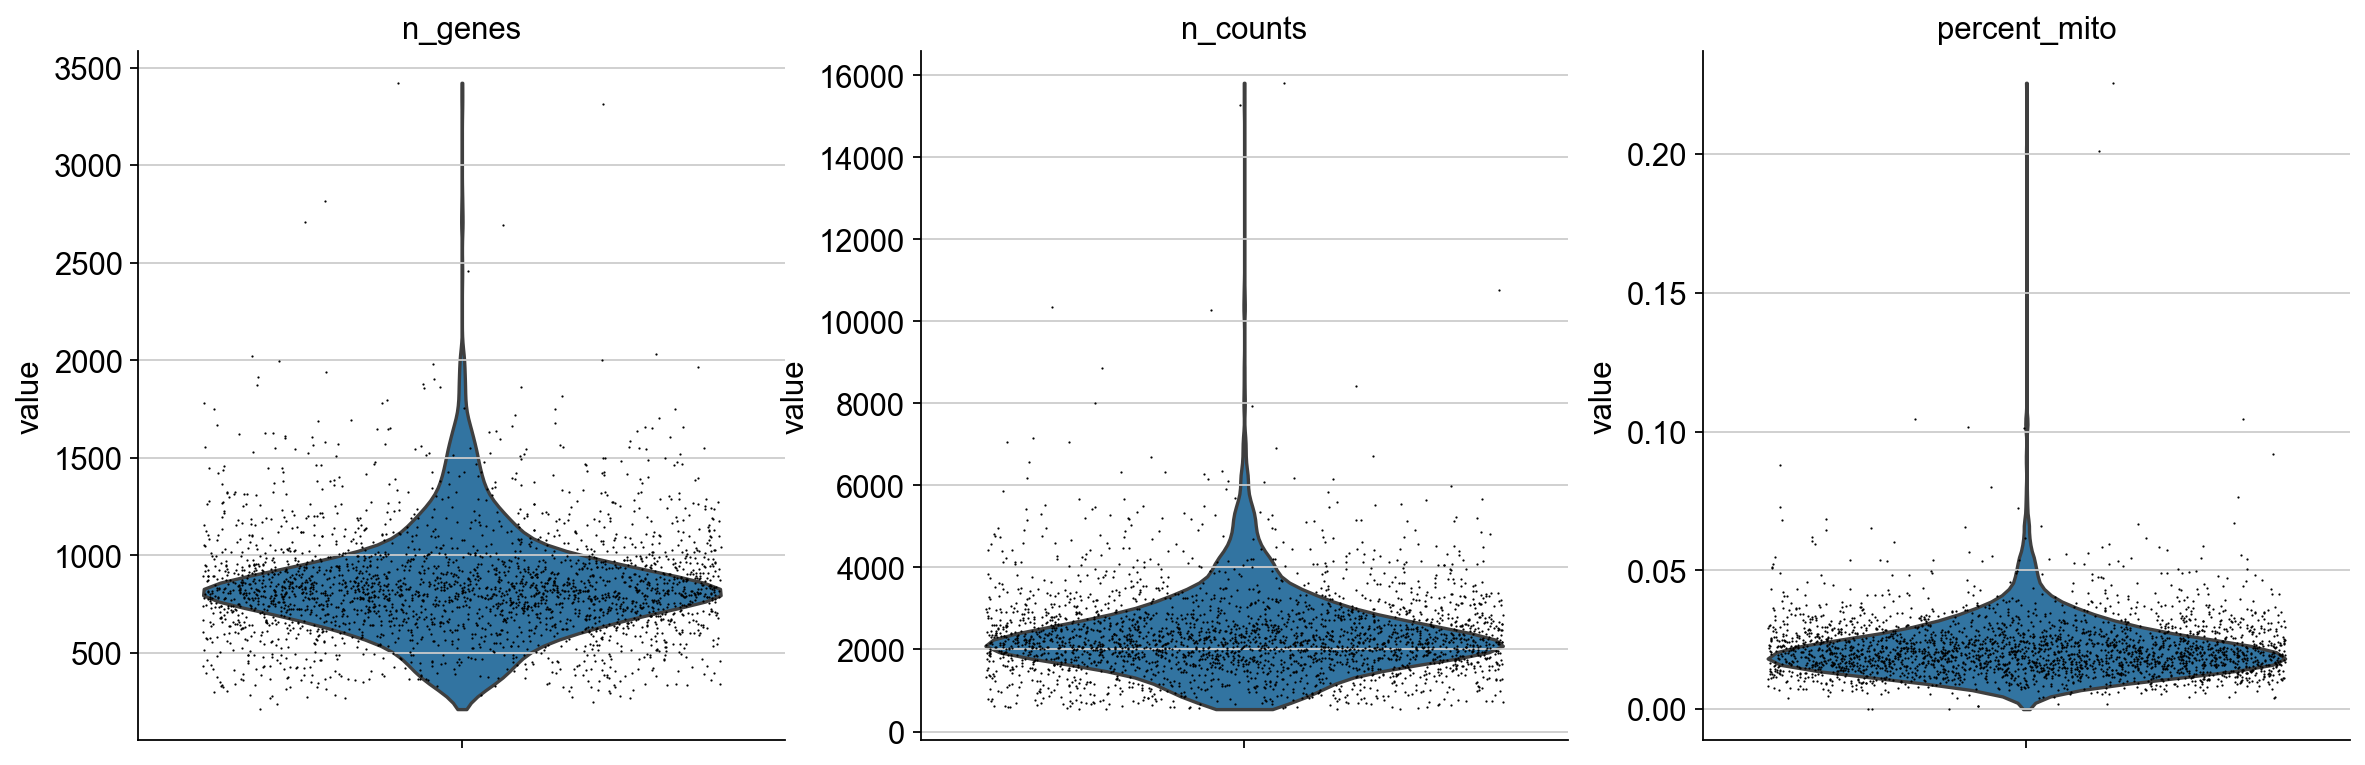

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [7]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [8]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [9]:
# Store the raw data
adata.raw = adata


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


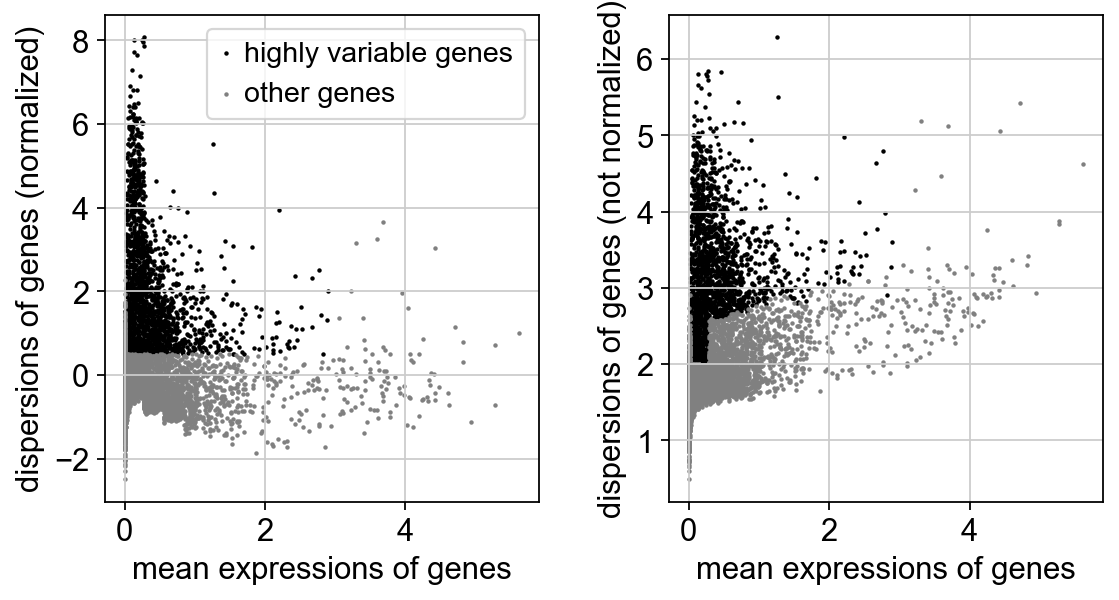

1838


In [10]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


In [11]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)


In [12]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Dimension Reduction

### Zifa

ZIFA has an n_componet like as K , I still did that since I didn't know when i started
I have tried n_genes 30, 100 & 500

In [14]:
# Import Libraries
from ZIFA import ZIFA
from ZIFA import block_ZIFA
import numpy as np



In [15]:
# ZIFA is designed to work with count data, so we need to make sure we're using the raw counts before normalization and log-transformation.
# If you have stored the raw data in adata.raw, you can use that; otherwise, make sure to use the original count data.
X_counts = adata.raw.X.toarray() if adata.raw is not None else adata.X.toarray()
X_counts.shape

(2638, 13714)

In [16]:
# Set the threshold for zero inflation
p0_thresh = 0.9  # This will filter out genes that are zero in more than 80% of cells

# Set the number of dimensions and blocks
n_components = 10 # ZIFA often works better with fewer components

# Set the number of genes per block to speed up the computation
n_genes_per_block = 100  # Adjust this number based on your dataset

# Calculate the number of blocks based on the new genes per block
n_blocks = max(int(X_counts.shape[1] / n_genes_per_block), 1)  # Ensure at least one block

# Fit the block ZIFA model
Z, model_params = block_ZIFA.fitModel(X_counts, n_components, n_blocks=n_blocks, p0_thresh=p0_thresh)

# The result is in Z, which we can add back to the AnnData object
adata.obsm['X_block_zifa'] = Z



Filtering out all genes which are zero in more than 90.0% of samples. To change this, change p0_thresh.
Running block zero-inflated factor analysis with N = 2638, D = 2125, K = 10, n_blocks = 137
Block sizes [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 85]


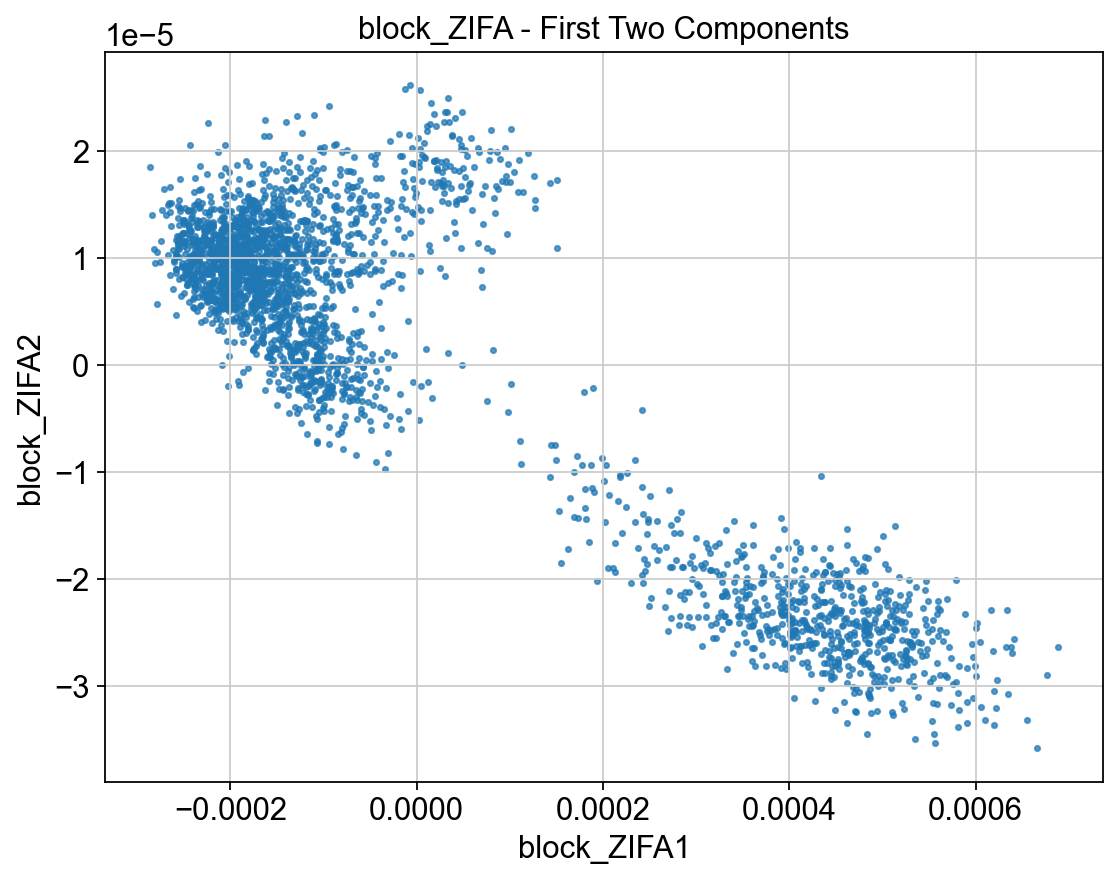

In [ ]:
# Visualize the results
# Extract the first two block_ZIFA components
block_zifa_comp1 = adata.obsm['X_block_zifa'][:, 0]
block_zifa_comp2 = adata.obsm['X_block_zifa'][:, 1]

# Create a scatter plot of the first two block_ZIFA components
plt.figure(figsize=(8, 6))
plt.scatter(block_zifa_comp1, block_zifa_comp2, s=5, alpha=0.7)
plt.title('block_ZIFA - First Two Components')
plt.xlabel('block_ZIFA1')
plt.ylabel('block_ZIFA2')
plt.show()


In [ ]:
# Write result file
adata.write('../write/pbmc3k_zifa.h5ad', compression='gzip')
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_block_zifa'

In [ ]:
# The result is in Z, which we can add back to the AnnData object
adata.obsm['X_block_zifa'] = Z

# Convert ZIFA results to DataFrame
zifa_df = pd.DataFrame(Z, index=adata.obs_names, columns=[f'ZIFA_dim{i+1}' for i in range(n_components)])

# Save to CSV file
zifa_df.to_csv('../csv_files/zifa_results.csv')